In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

## Loading Data
Data is loaded from images in the folder *"dataset/"*. There are two classes: *"true"* specifies images with the pedestrian using a smartphone, while *"false"* specifies images with the pedestrian not holding a smartphone. The images are loaded, shuffled and batched.

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

IMAGE_DIR = "dataset/"
MODEL_NAME = "smato_mobilenet_v2m"
SAVE_DIR = f"saved_models/{MODEL_NAME}/"

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(IMAGE_DIR,
                                                      shuffle = False,
                                                      seed = 141,
                                                      batch_size = None,
                                                      image_size = IMAGE_SIZE)
CLASS_NAMES = dataset.class_names
dataset_size = len(dataset)
dataset = dataset.shuffle(buffer_size = dataset_size, seed = 141, reshuffle_each_iteration = False)
# count images in each category
counts = {
    1: 0,
    0: 0
}
for i in dataset:
    _, cls = i
    counts[int(cls)] += 1
print("Number of pedestrians with a smartphone: ", counts[1])
print("Number of pedestrians without a smartphone: ", counts[0])

# batch the dataset
dataset = dataset.batch(batch_size = BATCH_SIZE)
print("Classes: ", CLASS_NAMES)
print("Total number of batches created: ", len(dataset))

Found 13866 files belonging to 2 classes.
Number of pedestrians with a smartphone:  3770
Number of pedestrians without a smartphone:  10096
Classes:  ['false', 'true']
Total number of batches created:  217


## Splitting Dataset
The dataset is split into training, validation, and test set. 85% of the dataset is reserved for training, while the rest is divided into validation and test dataset in the ratio of 60:40.

In [7]:
# train-validation split
num_batches = len(dataset)
val_dataset = dataset.take(int(num_batches * 0.15))
train_dataset = dataset.skip(int(num_batches * 0.15))

# validation-test split
num_val_batches = len(val_dataset)
test_dataset = val_dataset.take(int(num_val_batches * 0.4))
validation_dataset = val_dataset.skip(int(num_val_batches * 0.4))

In [8]:
print("Number of batches in Training Dataset: ", len(train_dataset))
print("Number of batches in Validation Dataset: ", len(validation_dataset))
print("Number of batches in Test Dataset: ", len(test_dataset))

Number of batches in Training Dataset:  185
Number of batches in Validation Dataset:  20
Number of batches in Test Dataset:  12


In [9]:
# rescale for tf hub - models on tf-hub require pixel values b/w 0 and 1
normalize = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalize(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalize(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalize(x), y))

In [10]:
# buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

## Model Definition
A model is defined using MobileNet-V2 as the feature extractor, followed by three fully connected hidden layers. Batch Normalization is performed after each FC layer, and dropout is used to reduce overfitting.

In [7]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    mobilenet_v2,
    trainable = False)

model = tf.keras.Sequential([
    
    tf.keras.layers.InputLayer(IMAGE_SIZE + (3, )),
    feature_extractor_layer,

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.6),
    
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1, activation = "sigmoid")
], name = MODEL_NAME)

model.summary()

Model: "smato_mobilenet_v2m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                               

## Metric for choosing best model: F1 Score

In [11]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

## Model Training
While training the model, only the best model is saved. This is decided by the metric accuracy on the validation set

In [9]:
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics = ['acc', f1]
)

In [10]:
NUM_EPOCHS = 50

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_DIR,
    save_weights_only = False,
    monitor = 'val_f1',
    mode = 'max',
    save_best_only = True
)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = NUM_EPOCHS,
                    callbacks = [model_checkpoint_callback])

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 0.6907 - acc: 0.6192 - f1: 0.3946INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 31s 121ms/step - loss: 0.6907 - acc: 0.6192 - f1: 0.3946 - val_loss: 0.5503 - val_acc: 0.7516 - val_f1: 0.4856
Epoch 2/50
185/185 [==============================] - 26s 105ms/step - loss: 0.5576 - acc: 0.7281 - f1: 0.4118 - val_loss: 0.4673 - val_acc: 0.7859 - val_f1: 0.4762
Epoch 3/50
184/185 [============================>.] - ETA: 0s - loss: 0.4990 - acc: 0.7671 - f1: 0.4578INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 31s 130ms/step - loss: 0.4989 - acc: 0.7670 - f1: 0.4579 - val_loss: 0.4524 - val_acc: 0.7867 - val_f1: 0.5412
Epoch 4/50
184/185 [============================>.] - ETA: 0s - loss: 0.4640 - acc: 0.7851 - f1: 0.4891INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 33s 138ms/step - loss: 0.4638 - acc: 0.7850 - f1: 0.4894 - val_loss: 0.4178 - val_acc: 0.8031 - val_f1: 0.5420
Epoch 5/50
184/185 [============================>.] - ETA: 0s - loss: 0.4302 - acc: 0.8012 - f1: 0.5411INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 34s 138ms/step - loss: 0.4298 - acc: 0.8014 - f1: 0.5422 - val_loss: 0.4002 - val_acc: 0.8109 - val_f1: 0.5632
Epoch 6/50
184/185 [============================>.] - ETA: 0s - loss: 0.4082 - acc: 0.8128 - f1: 0.5812INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 35s 141ms/step - loss: 0.4082 - acc: 0.8130 - f1: 0.5822 - val_loss: 0.3850 - val_acc: 0.8266 - val_f1: 0.6637
Epoch 7/50
185/185 [==============================] - 32s 125ms/step - loss: 0.3861 - acc: 0.8243 - f1: 0.6230 - val_loss: 0.3639 - val_acc: 0.8406 - val_f1: 0.6603
Epoch 8/50
185/185 [==============================] - ETA: 0s - loss: 0.3697 - acc: 0.8373 - f1: 0.6559INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 37s 148ms/step - loss: 0.3697 - acc: 0.8373 - f1: 0.6559 - val_loss: 0.3613 - val_acc: 0.8438 - val_f1: 0.6704
Epoch 9/50
184/185 [============================>.] - ETA: 0s - loss: 0.3552 - acc: 0.8372 - f1: 0.6626INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 40s 158ms/step - loss: 0.3550 - acc: 0.8374 - f1: 0.6634 - val_loss: 0.3479 - val_acc: 0.8469 - val_f1: 0.7135
Epoch 10/50
184/185 [============================>.] - ETA: 0s - loss: 0.3339 - acc: 0.8501 - f1: 0.6966INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 39s 155ms/step - loss: 0.3337 - acc: 0.8502 - f1: 0.6972 - val_loss: 0.3376 - val_acc: 0.8531 - val_f1: 0.7370
Epoch 11/50
185/185 [==============================] - ETA: 0s - loss: 0.3204 - acc: 0.8597 - f1: 0.7222INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 41s 159ms/step - loss: 0.3204 - acc: 0.8597 - f1: 0.7222 - val_loss: 0.3297 - val_acc: 0.8492 - val_f1: 0.7421
Epoch 12/50
185/185 [==============================] - 37s 141ms/step - loss: 0.3101 - acc: 0.8637 - f1: 0.7301 - val_loss: 0.3253 - val_acc: 0.8617 - val_f1: 0.7186
Epoch 13/50
185/185 [==============================] - ETA: 0s - loss: 0.2965 - acc: 0.8690 - f1: 0.7408INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 42s 165ms/step - loss: 0.2965 - acc: 0.8690 - f1: 0.7408 - val_loss: 0.3352 - val_acc: 0.8438 - val_f1: 0.7484
Epoch 14/50
185/185 [==============================] - ETA: 0s - loss: 0.2750 - acc: 0.8826 - f1: 0.7693INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 43s 166ms/step - loss: 0.2750 - acc: 0.8826 - f1: 0.7693 - val_loss: 0.2985 - val_acc: 0.8641 - val_f1: 0.7601
Epoch 15/50
185/185 [==============================] - ETA: 0s - loss: 0.2756 - acc: 0.8852 - f1: 0.7774INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 45s 172ms/step - loss: 0.2756 - acc: 0.8852 - f1: 0.7774 - val_loss: 0.2983 - val_acc: 0.8758 - val_f1: 0.7656
Epoch 16/50
184/185 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.8935 - f1: 0.7931INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 46s 176ms/step - loss: 0.2584 - acc: 0.8935 - f1: 0.7932 - val_loss: 0.2971 - val_acc: 0.8680 - val_f1: 0.7700
Epoch 17/50
184/185 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.8967 - f1: 0.8017INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 48s 184ms/step - loss: 0.2466 - acc: 0.8969 - f1: 0.8024 - val_loss: 0.2838 - val_acc: 0.8695 - val_f1: 0.7750
Epoch 18/50
185/185 [==============================] - 44s 162ms/step - loss: 0.2304 - acc: 0.9043 - f1: 0.8142 - val_loss: 0.2956 - val_acc: 0.8844 - val_f1: 0.7734
Epoch 19/50
185/185 [==============================] - 44s 165ms/step - loss: 0.2339 - acc: 0.9035 - f1: 0.8145 - val_loss: 0.3075 - val_acc: 0.8578 - val_f1: 0.7668
Epoch 20/50
184/185 [============================>.] - ETA: 0s - loss: 0.2173 - acc: 0.9061 - f1: 0.8185INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 53s 204ms/step - loss: 0.2173 - acc: 0.9058 - f1: 0.8180 - val_loss: 0.2905 - val_acc: 0.8773 - val_f1: 0.7931
Epoch 21/50
185/185 [==============================] - 49s 180ms/step - loss: 0.2065 - acc: 0.9141 - f1: 0.8359 - val_loss: 0.3313 - val_acc: 0.8867 - val_f1: 0.7640
Epoch 22/50
185/185 [==============================] - 49s 183ms/step - loss: 0.1982 - acc: 0.9177 - f1: 0.8410 - val_loss: 0.3114 - val_acc: 0.8672 - val_f1: 0.7804
Epoch 23/50
185/185 [==============================] - 50s 183ms/step - loss: 0.1922 - acc: 0.9227 - f1: 0.8510 - val_loss: 0.2836 - val_acc: 0.8891 - val_f1: 0.7863
Epoch 24/50
185/185 [==============================] - ETA: 0s - loss: 0.1868 - acc: 0.9186 - f1: 0.8422INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 55s 207ms/step - loss: 0.1868 - acc: 0.9186 - f1: 0.8422 - val_loss: 0.2731 - val_acc: 0.8930 - val_f1: 0.8002
Epoch 25/50
185/185 [==============================] - 53s 194ms/step - loss: 0.1778 - acc: 0.9267 - f1: 0.8585 - val_loss: 0.2867 - val_acc: 0.8914 - val_f1: 0.7870
Epoch 26/50
185/185 [==============================] - ETA: 0s - loss: 0.1749 - acc: 0.9245 - f1: 0.8539INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 57s 216ms/step - loss: 0.1749 - acc: 0.9245 - f1: 0.8539 - val_loss: 0.2702 - val_acc: 0.8961 - val_f1: 0.8091
Epoch 27/50
185/185 [==============================] - ETA: 0s - loss: 0.1647 - acc: 0.9320 - f1: 0.8672INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 58s 217ms/step - loss: 0.1647 - acc: 0.9320 - f1: 0.8672 - val_loss: 0.2392 - val_acc: 0.9023 - val_f1: 0.8158
Epoch 28/50
185/185 [==============================] - 54s 199ms/step - loss: 0.1564 - acc: 0.9358 - f1: 0.8755 - val_loss: 0.2634 - val_acc: 0.9070 - val_f1: 0.8093
Epoch 29/50
185/185 [==============================] - 54s 199ms/step - loss: 0.1601 - acc: 0.9327 - f1: 0.8715 - val_loss: 0.2804 - val_acc: 0.8969 - val_f1: 0.7897
Epoch 30/50
185/185 [==============================] - 53s 195ms/step - loss: 0.1582 - acc: 0.9332 - f1: 0.8710 - val_loss: 0.3087 - val_acc: 0.8984 - val_f1: 0.7859
Epoch 31/50
184/185 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9400 - f1: 0.8849INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 57s 215ms/step - loss: 0.1436 - acc: 0.9400 - f1: 0.8851 - val_loss: 0.2511 - val_acc: 0.8969 - val_f1: 0.8185
Epoch 32/50
185/185 [==============================] - 55s 201ms/step - loss: 0.1395 - acc: 0.9413 - f1: 0.8880 - val_loss: 0.2756 - val_acc: 0.9055 - val_f1: 0.8051
Epoch 33/50
185/185 [==============================] - ETA: 0s - loss: 0.1313 - acc: 0.9440 - f1: 0.8911INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 60s 225ms/step - loss: 0.1313 - acc: 0.9440 - f1: 0.8911 - val_loss: 0.2584 - val_acc: 0.9047 - val_f1: 0.8257
Epoch 34/50
184/185 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9428 - f1: 0.8884INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 59s 220ms/step - loss: 0.1275 - acc: 0.9429 - f1: 0.8886 - val_loss: 0.2415 - val_acc: 0.9078 - val_f1: 0.8347
Epoch 35/50
185/185 [==============================] - 56s 203ms/step - loss: 0.1298 - acc: 0.9465 - f1: 0.8971 - val_loss: 0.2580 - val_acc: 0.9039 - val_f1: 0.8288
Epoch 36/50
184/185 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9457 - f1: 0.8953INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 60s 227ms/step - loss: 0.1255 - acc: 0.9458 - f1: 0.8955 - val_loss: 0.2695 - val_acc: 0.9211 - val_f1: 0.8428
Epoch 37/50
185/185 [==============================] - 56s 205ms/step - loss: 0.1299 - acc: 0.9455 - f1: 0.8935 - val_loss: 0.2523 - val_acc: 0.9062 - val_f1: 0.8283
Epoch 38/50
185/185 [==============================] - 56s 205ms/step - loss: 0.1140 - acc: 0.9502 - f1: 0.9044 - val_loss: 0.2880 - val_acc: 0.9055 - val_f1: 0.8119
Epoch 39/50
185/185 [==============================] - 56s 207ms/step - loss: 0.1221 - acc: 0.9479 - f1: 0.8991 - val_loss: 0.2393 - val_acc: 0.9133 - val_f1: 0.8321
Epoch 40/50
184/185 [============================>.] - ETA: 0s - loss: 0.1167 - acc: 0.9505 - f1: 0.9050INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


INFO:tensorflow:Assets written to: saved_models/smato_mobilenet_v2m\assets


185/185 [==============================] - 60s 227ms/step - loss: 0.1168 - acc: 0.9505 - f1: 0.9051 - val_loss: 0.2347 - val_acc: 0.9180 - val_f1: 0.8493
Epoch 41/50
185/185 [==============================] - 58s 214ms/step - loss: 0.1065 - acc: 0.9633 - f1: 0.9313 - val_loss: 0.2787 - val_acc: 0.9164 - val_f1: 0.8405
Epoch 42/50
185/185 [==============================] - 58s 212ms/step - loss: 0.1045 - acc: 0.9632 - f1: 0.9333 - val_loss: 0.2427 - val_acc: 0.9180 - val_f1: 0.8464
Epoch 43/50
185/185 [==============================] - 58s 212ms/step - loss: 0.1091 - acc: 0.9611 - f1: 0.9287 - val_loss: 0.2811 - val_acc: 0.9172 - val_f1: 0.8431
Epoch 44/50
185/185 [==============================] - 59s 214ms/step - loss: 0.0993 - acc: 0.9643 - f1: 0.9345 - val_loss: 0.2645 - val_acc: 0.9125 - val_f1: 0.8371
Epoch 45/50
185/185 [==============================] - 59s 216ms/step - loss: 0.1009 - acc: 0.9632 - f1: 0.9317 - val_loss: 0.3151 - val_acc: 0.9000 - val_f1: 0.7970
Epoch 46/50
185/

## Model Evaluation
The best trained model is loaded and the test dataset is used for evaluating performance on data never been used in this process.

In [12]:
model = keras.models.load_model(SAVE_DIR, custom_objects = {"f1": f1})
model.evaluate(test_dataset)

12/12 [==============================] - 8s 45ms/step - loss: 0.2132 - acc: 0.9271 - f1: 0.8768


[0.21317045390605927, 0.9270833134651184, 0.8767540454864502]

## Example Images
A bunch of images from the test dataset are chosen to show the performance of the model and to understand the reasons for misclassification.

Predictions:
 [1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
Labels:
 [1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1]


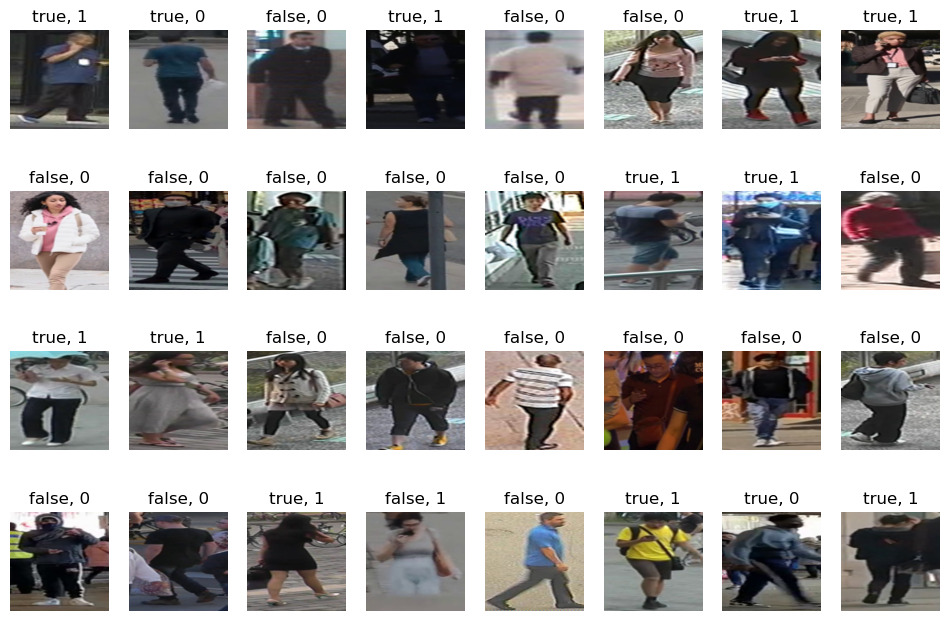

In [13]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.shuffle(10, seed = None).take(1).as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch[: 32]).flatten()

predictions = np.where(predictions < 0.5, 0, 1)
label_batch = label_batch[: 32]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 8))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(str(CLASS_NAMES[predictions[i]]) + ", " + str(label_batch[i]))
    plt.axis("off")